In [1]:
# Import the following libraries that we will use: nibabel, matplotlib, numpy
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
import os

## Loading NIFTI images using NiBabel

In [2]:
# Our data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label

train_path = "../data/TrainingSet"
images = [(path, nib.load(path)) for path in sorted(glob(os.path.join(train_path, 'images', '*.nii.gz')))]
labels = [(path, nib.load(path)) for path in sorted(glob(os.path.join(train_path, 'labels', '*.nii.gz')))]

In [3]:
#  Inspecting the size of each volume and its corresponding segmentation mask

for i in range(len(images)):
    print(f"{i+1:0>3}   image {images[i][1].get_fdata().shape}    ||     label {labels[i][1].get_fdata().shape}")

001   image (35, 51, 35)    ||     label (35, 51, 35)
002   image (34, 52, 35)    ||     label (34, 52, 35)
003   image (36, 52, 38)    ||     label (36, 52, 38)
004   image (35, 52, 34)    ||     label (35, 52, 34)
005   image (34, 47, 40)    ||     label (34, 47, 40)
006   image (36, 48, 40)    ||     label (36, 48, 40)
007   image (512, 512, 241)    ||     label (36, 50, 31)
008   image (36, 50, 31)    ||     label (36, 50, 31)
009   image (39, 50, 40)    ||     label (39, 50, 40)
010   image (42, 51, 28)    ||     label (42, 51, 28)
011   image (35, 48, 32)    ||     label (35, 48, 32)
012   image (36, 47, 41)    ||     label (36, 47, 41)
013   image (36, 46, 43)    ||     label (36, 46, 43)
014   image (35, 51, 35)    ||     label (35, 51, 35)
015   image (38, 52, 33)    ||     label (38, 52, 33)
016   image (35, 48, 35)    ||     label (35, 48, 35)
017   image (36, 50, 36)    ||     label (36, 50, 36)
018   image (33, 48, 38)    ||     label (33, 48, 38)
019   image (36, 49, 40) 

In [4]:
image = images[0][1].get_fdata()
label = labels[0][1].get_fdata()

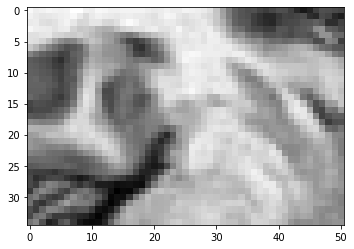

In [5]:
plt.imshow(image[:, :, 20], cmap='gray')

In [6]:
#  Visualizing some slices with their corresponding mask

def show_n_slices(img_arr, lbl_arr, slices=None, aspect_ratio = [1, 1, 1]):
    '''
    This function visualize N slices along with their labels
    img_arr: numpy array of the image
    lbl_arr: numpy array of the label
    slices: list of the slices of interest (integers) [axial, coronal, sagittal] to visualize
    if None, would show the central slices
    aspect_ratio: list of aspect ratios for axial, coronal, sagittal ([1,1,1] is default)
    '''
    img_arr = np.flip(img_arr.T)
    lbl_arr = np.flip(lbl_arr.T)

    _, ax = plt.subplots(2, 3, figsize=[10,6], constrained_layout=True)
    
    if slices is None:
        slice_ax_n = int(img_arr.shape[0] / 2)
        slice_cor_n = int(img_arr.shape[1] / 2)
        slice_sag_n = int(img_arr.shape[2] / 2)
    elif (slices[0] <= img_arr.shape[0]) & (slices[1] <= img_arr.shape[1]) & (slices[2] <= img_arr.shape[2]):
        slice_ax_n = int(slices[0])
        slice_cor_n = int(slices[1])
        slice_sag_n = int(slices[2])     
    else:
        return print('Wrong slices set')
    
    ax[0, 0].set_title(f'Axial slice {slice_ax_n}')
    ax[0, 0].imshow(img_arr[slice_ax_n, :, :], cmap='gray', \
                                  aspect = aspect_ratio[0], )
    ax[1, 0].set_title(f'Label for axial slice {slice_ax_n}')
    ax[1, 0].imshow(lbl_arr[slice_ax_n, :, :], cmap='gray', \
                                  aspect = aspect_ratio[0])
    
    ax[0, 1].set_title(f'Coronal slice {slice_cor_n}')
    ax[0, 1].imshow(img_arr[:, slice_cor_n, :], cmap='gray', \
                                  aspect = aspect_ratio[1])
    ax[1, 1].set_title(f'Label for coronal slice {slice_cor_n}')
    ax[1, 1].imshow(lbl_arr[:, slice_cor_n, :], cmap='gray', \
                                  aspect = aspect_ratio[1])
    
    ax[0, 2].set_title(f'Sagittal slice {slice_sag_n}')
    ax[0, 2].imshow(img_arr[:, :, slice_sag_n], cmap='gray', \
                                  aspect = aspect_ratio[2])
    ax[1, 2].set_title(f'Label for sagittal slice {slice_sag_n}')
    ax[1, 2].imshow(lbl_arr[:, :, slice_sag_n], cmap='gray', \
                                  aspect = aspect_ratio[2])    
    plt.show()

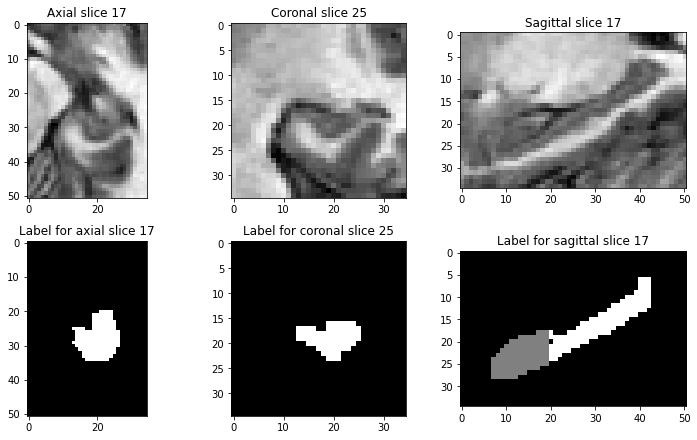

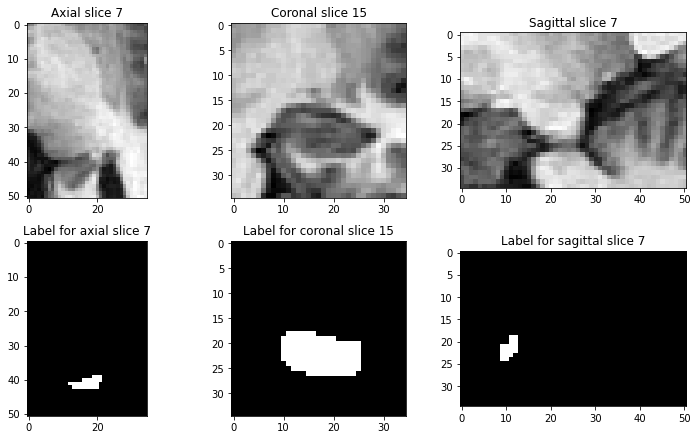

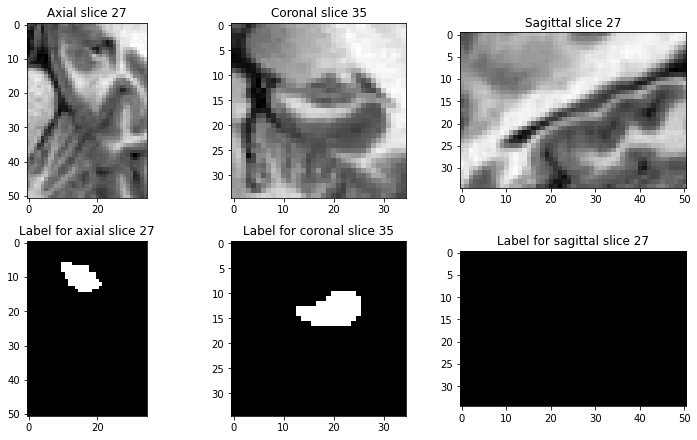

In [7]:
show_n_slices(image, label)
show_n_slices(image, label, slices=[7,15,7])
show_n_slices(image, label, slices=[27,35,27])

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [8]:
# Using .header_class attribute to get the format of our images
images[0][1].header_class

nibabel.nifti1.Nifti1Header

Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [9]:
# How many bits per pixel are used?
images[0][1].header['bitpix']

array(8, dtype=int16)

In [10]:
# What are the units of measurement?
# dictionary for units
xyzt_units_dic = {0: 'Unknown', 1: 'Meter (m)', 2: 'Milimeter (mm)', 3: 'Micron (µm)'}

# need to convert to binary, extract first 2 bits, and then conver to decimals (base 2)
coded_unit = int(bin(images[0][1].header["xyzt_units"])[:4], 2)
print(f'Units of measurement are {xyzt_units_dic[coded_unit]}')

Units of measurement are Milimeter (mm)


In [11]:
# Do we have a regular grid? What are grid spacings?
images[0][1].header['pixdim']

array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

In [12]:
# What dimensions represent axial, sagittal, and coronal slices? How do you know?
images[0][1].header['dim']

array([ 3, 35, 51, 35,  1,  1,  1,  1], dtype=int16)

In [13]:
# Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500
print((label>0).sum())

2948


(array([126., 132.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 2382.,  3298.,  4214.,  5130.,  6046.,  6962.,  7878.,  8794.,
         9710., 10626., 11542., 12458., 13374., 14290., 15206., 16122.,
        17038., 17954., 18870., 19786., 20702.]),
 <BarContainer object of 20 artists>)

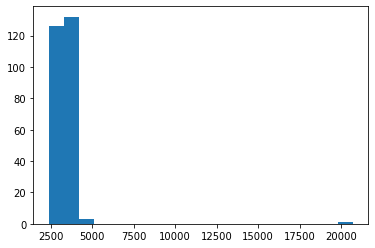

In [14]:
plt.hist([(label[1].get_fdata()>0).sum() for label in labels], bins=20)

In [15]:
len(images), len(labels)

(262, 262)

## Get the outliers and clean the dataset

In [16]:
# Detect outliers
outliers_indecies = []

for i in range(len(images)):
    if list(images[i][1].header['pixdim'][1:4]) != list(labels[i][1].header['pixdim'][1:4]):
        outliers_indecies.append(i)
    elif list(images[i][1].header['dim'][1:4]) != list(labels[i][1].header['dim'][1:4]):
        outliers_indecies.append(i)
    elif (labels[i][1].get_fdata()>0).sum() < 2500 or (labels[i][1].get_fdata()>0).sum() > 4900:
        outliers_indecies.append(i)    

for idx, i in enumerate(outliers_indecies):
    del images[i-idx]
    del labels[i-idx]

In [17]:
len(images), len(labels)

(252, 252)

(array([11., 13.,  9., 14., 14., 13., 21., 19., 19., 24., 18., 17., 22.,
        10.,  9., 11.,  4.,  1.,  1.,  2.]),
 array([2532.  , 2625.45, 2718.9 , 2812.35, 2905.8 , 2999.25, 3092.7 ,
        3186.15, 3279.6 , 3373.05, 3466.5 , 3559.95, 3653.4 , 3746.85,
        3840.3 , 3933.75, 4027.2 , 4120.65, 4214.1 , 4307.55, 4401.  ]),
 <BarContainer object of 20 artists>)

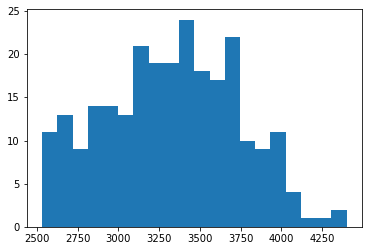

In [18]:
# Plot a histogram of all volumes that we have in our dataset and see how our dataset 
# measures against a slice of a normal population represented by the chart below.
plt.hist([(label[1].get_fdata()>0).sum() for label in labels], bins=20)

In [19]:
# Copy the clean dataset to the output folder inside EDA/out. You will use it in the next Section
import shutil

for i in range(len(images)):
    shutil.copy(images[i][0], './out/images/')
    shutil.copy(labels[i][0], './out/labels/')